In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simulators.ricker import ricker
import utils.corruption as corruption
from itertools import permutations
from utils.metrics import *
import random
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def RMSE(gt, samples, p=1):
    if p == 1:
        dist = torch.mean(torch.abs(gt-samples))
    elif p == 2:
        dist = torch.sqrt(torch.mean((gt-samples)**2))
    elif p == 3:
        dist = torch.nn.functional.pairwise_distance(gt, samples, p=2).mean()
    else:
        dist = metrics.MMD_unweighted(samples, gt.reshape(-1, 2), lengthscale=metrics.median_heuristic(samples))
    return dist

In [166]:
x = torch.tensor(np.load("data/ricker_x_4000.npy")).reshape(4000, 100, 100).to(device)

theta = np.load("data/ricker_theta_4000.npy")

dataloader = DataLoader(x[:1000], batch_size=50, shuffle=True)

theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt)
sigma = torch.tensor(40)
obs_cont = corruption.magnitude_sigma(obs, var=sigma, length=100).reshape(-1, 100, 100).to(device)
print(obs_cont.shape)

torch.Size([1, 100, 100])


In [4]:
def regression_ABC(s_obs, param, sumStats, p):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)
    sumStats = sumStats
    s_obs = s_obs

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted
    

In [5]:
class RickerSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(RickerSummary, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        
        self.encoder = nn.Sequential(nn.Conv1d(self.input_size, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     nn.Conv1d(4, 4, 3, 4),
                                     )
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, 4, 3, 4),
                                     nn.ConvTranspose1d(4, self.input_size, 3, 4),
                                     nn.Upsample(100)
                                     )

    def forward(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100))
        output = self.decoder(embeddings.reshape(-1, 4, 1)).reshape(-1, 100, 100)
        return output
    
    def forward_encoder(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 100)).reshape(-1, 100, 4)
        return embeddings

In [28]:
def solve_normal():
    summary_net_normal = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_normal.parameters(), lr=0.01)

    # Train the model for some number of epochs
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_normal(inputs)
            loss = criterion(outputs, inputs) / 10000

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_normal

In [30]:
s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

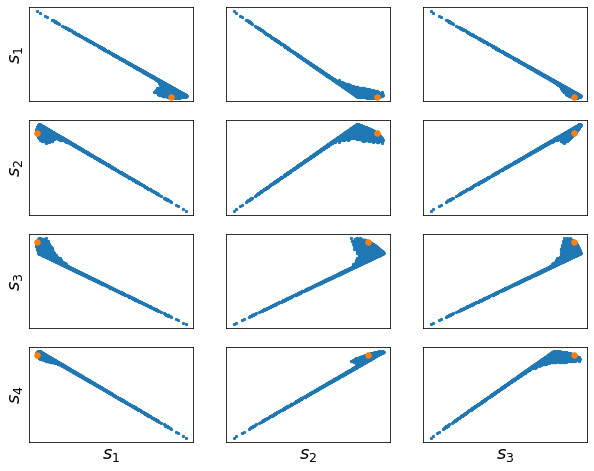

In [17]:
stat = list(permutations(range(4), 2))

plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_normal[:, stat[i][1]], s_normal[:, stat[i][0]], s=5)
    plt.scatter(s_obs_normal[0, stat[i][1]], s_obs_normal[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%3==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-3 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")

# Robust

In [44]:
def solve_robust(beta):
    summary_net_robust = RickerSummary(1, 4).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_robust.parameters(), lr=0.01)

    index_list = [int(i) for i in range(len(x))]

    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_robust(inputs)

            random.shuffle(index_list)
            context_embeddings = torch.mean(summary_net_robust.forward_encoder(x[index_list[:200]]), dim=1)
            obs_embeddings = torch.mean(summary_net_robust.forward_encoder(obs_cont), dim=1)

            ae_loss = criterion(outputs, inputs) / 10000
            summary_loss = MMD_unweighted(context_embeddings, obs_embeddings, lengthscale=median_heuristic(context_embeddings))

            loss = ae_loss + beta*summary_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_robust

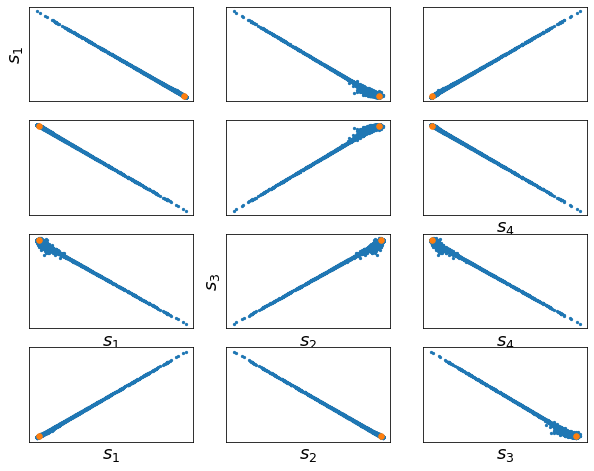

In [22]:
s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

stat = list(permutations(range(4), 2))
plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_robust[:, stat[i][1]], s_robust[:, stat[i][0]], s=5)
    plt.scatter(s_obs_robust[0, stat[i][1]], s_obs_robust[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")


In [23]:
posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


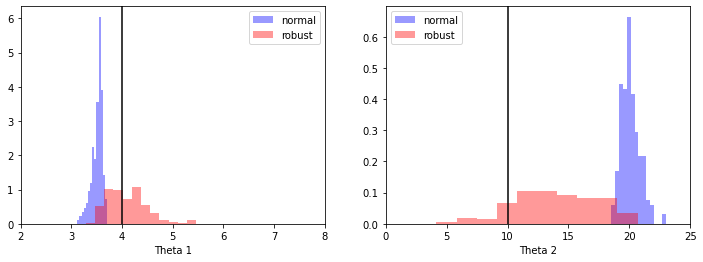

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()

In [25]:
RMSE(torch.tensor([4, 10]), torch.tensor(posterior_robust), 2)

tensor(3.6704, dtype=torch.float64)

In [26]:
RMSE(torch.tensor([4, 10]), torch.tensor(posterior_normal), 2)

tensor(7.1690, dtype=torch.float64)

In [63]:
n_sims = 50
beta = 2
for i in range(n_sims):
    print(f"Simulation {i}")
    summary_net_normal = solve_normal()
    s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
    s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
    posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)
    
    summary_net_robust = solve_robust(beta)
    s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
    s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
    posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)
    
    root_name = f'objects/ABC/ricker/lambda={beta}/' + str(i)
    if not os.path.exists(root_name):
        os.makedirs(root_name)
    np.save(root_name + '/posterior_normal.npy', posterior_normal)
    np.save(root_name + '/posterior_robust.npy', posterior_robust)

Simulation 0
Epoch 1, Loss: 14.952318000793458
Epoch 2, Loss: 12.17743992805481
Epoch 3, Loss: 12.061065983772277
Epoch 4, Loss: 12.001991200447083
Epoch 5, Loss: 11.97520717382431
Epoch 6, Loss: 11.966055488586425
Epoch 7, Loss: 11.96399564743042
Epoch 8, Loss: 11.962627255916596
Epoch 9, Loss: 11.96113760471344
Epoch 10, Loss: 11.95962702035904
Epoch 1, Loss: 16.54434230327606
Epoch 2, Loss: 12.601263523101807
Epoch 3, Loss: 12.364054489135743
Epoch 4, Loss: 12.340549778938293
Epoch 5, Loss: 12.341608834266662
Epoch 6, Loss: 12.335032677650451
Epoch 7, Loss: 12.34369466304779
Epoch 8, Loss: 12.33883512020111
Epoch 9, Loss: 12.3258127450943
Epoch 10, Loss: 12.338024568557739
Simulation 1
Epoch 1, Loss: 15.152965462207794
Epoch 2, Loss: 12.223693037033081
Epoch 3, Loss: 12.030696916580201
Epoch 4, Loss: 12.009063851833343
Epoch 5, Loss: 11.982839775085449
Epoch 6, Loss: 11.968459391593933
Epoch 7, Loss: 11.96346049308777
Epoch 8, Loss: 11.960501742362975
Epoch 9, Loss: 11.9581836938858

Epoch 9, Loss: 12.320513057708741
Epoch 10, Loss: 12.320618176460266
Simulation 12
Epoch 1, Loss: 15.700411438941956
Epoch 2, Loss: 12.317256784439087
Epoch 3, Loss: 12.054537367820739
Epoch 4, Loss: 12.019063448905944
Epoch 5, Loss: 12.004531490802766
Epoch 6, Loss: 11.992785906791687
Epoch 7, Loss: 11.983560562133789
Epoch 8, Loss: 11.975749385356902
Epoch 9, Loss: 11.969436693191529
Epoch 10, Loss: 11.964683246612548
Epoch 1, Loss: 15.169240236282349
Epoch 2, Loss: 12.539753675460815
Epoch 3, Loss: 12.376427555084229
Epoch 4, Loss: 12.341143321990966
Epoch 5, Loss: 12.34354214668274
Epoch 6, Loss: 12.329995393753052
Epoch 7, Loss: 12.332685470581055
Epoch 8, Loss: 12.318779110908508
Epoch 9, Loss: 12.324671697616576
Epoch 10, Loss: 12.317684006690978
Simulation 13
Epoch 1, Loss: 17.098804569244386
Epoch 2, Loss: 12.597349381446838
Epoch 3, Loss: 12.067159152030944
Epoch 4, Loss: 12.000277113914489
Epoch 5, Loss: 11.977542948722839
Epoch 6, Loss: 11.967967295646668
Epoch 7, Loss: 11.

Epoch 6, Loss: 12.330375993251801
Epoch 7, Loss: 12.319573020935058
Epoch 8, Loss: 12.319889354705811
Epoch 9, Loss: 12.326866459846496
Epoch 10, Loss: 12.322054815292358
Simulation 24
Epoch 1, Loss: 17.11818931102753
Epoch 2, Loss: 12.548853135108947
Epoch 3, Loss: 12.072473537921905
Epoch 4, Loss: 12.00171047449112
Epoch 5, Loss: 11.980556988716126
Epoch 6, Loss: 11.973034358024597
Epoch 7, Loss: 11.96821174621582
Epoch 8, Loss: 11.965251350402832
Epoch 9, Loss: 11.963833713531494
Epoch 10, Loss: 11.96293466091156
Epoch 1, Loss: 16.694319438934325
Epoch 2, Loss: 12.927042031288147
Epoch 3, Loss: 12.390544414520264
Epoch 4, Loss: 12.338796138763428
Epoch 5, Loss: 12.342245292663574
Epoch 6, Loss: 12.33779022693634
Epoch 7, Loss: 12.337195038795471
Epoch 8, Loss: 12.335091018676758
Epoch 9, Loss: 12.329283523559571
Epoch 10, Loss: 12.325717306137085
Simulation 25
Epoch 1, Loss: 14.451922011375427
Epoch 2, Loss: 12.142073702812194
Epoch 3, Loss: 12.022981142997741
Epoch 4, Loss: 11.9854

Epoch 3, Loss: 12.375371193885803
Epoch 4, Loss: 12.331654858589172
Epoch 5, Loss: 12.329033660888673
Epoch 6, Loss: 12.323212170600891
Epoch 7, Loss: 12.32667543888092
Epoch 8, Loss: 12.32846245765686
Epoch 9, Loss: 12.315975046157837
Epoch 10, Loss: 12.324586033821106
Simulation 36
Epoch 1, Loss: 15.411558794975281
Epoch 2, Loss: 12.343352675437927
Epoch 3, Loss: 12.068720984458924
Epoch 4, Loss: 11.997651410102844
Epoch 5, Loss: 11.979444360733032
Epoch 6, Loss: 11.96924331188202
Epoch 7, Loss: 11.964161491394043
Epoch 8, Loss: 11.962040972709655
Epoch 9, Loss: 11.960743892192841
Epoch 10, Loss: 11.96035257577896
Epoch 1, Loss: 17.718202328681947
Epoch 2, Loss: 13.38570532798767
Epoch 3, Loss: 12.599762177467346
Epoch 4, Loss: 12.365277910232544
Epoch 5, Loss: 12.341109800338746
Epoch 6, Loss: 12.342023253440857
Epoch 7, Loss: 12.328532361984253
Epoch 8, Loss: 12.328283715248109
Epoch 9, Loss: 12.331474041938781
Epoch 10, Loss: 12.333893132209777
Simulation 37
Epoch 1, Loss: 15.4637

Epoch 10, Loss: 11.958890163898468
Epoch 1, Loss: 17.27682993412018
Epoch 2, Loss: 12.869715571403503
Epoch 3, Loss: 12.458070731163025
Epoch 4, Loss: 12.350241661071777
Epoch 5, Loss: 12.327595269680023
Epoch 6, Loss: 12.32913830280304
Epoch 7, Loss: 12.32762793302536
Epoch 8, Loss: 12.325074672698975
Epoch 9, Loss: 12.325568008422852
Epoch 10, Loss: 12.324377489089965
Simulation 48
Epoch 1, Loss: 16.249027681350707
Epoch 2, Loss: 12.505734372138978
Epoch 3, Loss: 12.075820636749267
Epoch 4, Loss: 11.996466064453125
Epoch 5, Loss: 11.977199006080628
Epoch 6, Loss: 11.970465612411498
Epoch 7, Loss: 11.967643904685975
Epoch 8, Loss: 11.966130089759826
Epoch 9, Loss: 11.965025377273559
Epoch 10, Loss: 11.964295363426208
Epoch 1, Loss: 16.028105568885803
Epoch 2, Loss: 12.600499677658082
Epoch 3, Loss: 12.396187782287598
Epoch 4, Loss: 12.343970370292663
Epoch 5, Loss: 12.33251895904541
Epoch 6, Loss: 12.326111078262329
Epoch 7, Loss: 12.32096724510193
Epoch 8, Loss: 12.320332956314086
Ep

In [191]:
n_sims = 50
beta = 5
rmse_normal = np.zeros(n_sims)
rmse_robust = np.zeros(n_sims)
for i in range(n_sims):
    root_name = root_name = f'objects/ABC/ricker/lambda={beta}/' + str(i)
    posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
    posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))
    rmse_normal[i] = RMSE(torch.tensor([4, 10]), posterior_normal, 2)
    rmse_robust[i] = RMSE(torch.tensor([4, 10]), posterior_robust, 2)

print("RMSE mean for normal model: ", np.mean(rmse_normal))
print("RMSE mean for robust model: ", np.mean(rmse_robust))
print("RMSE std for normal model: ", np.std(rmse_normal))
print("RMSE std for robust model: ", np.std(rmse_robust))

RMSE mean for normal model:  7.067988529761993
RMSE mean for robust model:  3.891314436146103
RMSE std for normal model:  0.3422907645779606
RMSE std for robust model:  1.1737282202563097


In [184]:
root_name = root_name = f'objects/ABC/ricker/lambda=5/5'
posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))

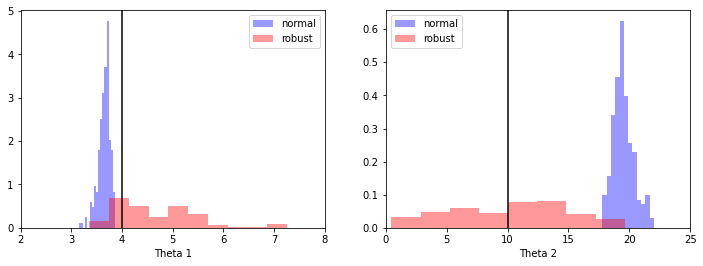

In [185]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()

In [173]:
def ricker_1(theta):
    logr = theta[0]
    phi = theta[1]
    sigma = 0.3

    N0 = 1
    T = 100
    nSamples = 1

    Y = torch.zeros(size=(nSamples, T))

    for i in range(nSamples):
        et = torch.randn(T, )
        Nt = torch.zeros(size=(T + 1,))

        Nt[0] = N0

        for t in range(1, T + 1):
            Nt[t] = torch.exp(logr + torch.log(Nt[t - 1]) - Nt[t - 1] + sigma * et[t - 1])
            Y[i, t - 1] = torch.poisson(phi * Nt[t])

    return Y

In [186]:
predictive_normal = np.zeros([200, 100])
for i in range(200):
    predictive_normal[i] = ricker_1(posterior_normal[i])[0]

In [187]:
from scipy.stats import multivariate_normal

mu_normal = np.mean(predictive_normal, axis=0)

cov_normal = np.cov(predictive_normal, rowvar=0)

mvn = multivariate_normal(mean=mu_normal, cov=cov_normal)

for i in range(100):
    log_likelihood += mvn.logpdf(obs_cont[0, i])
print(log_likelihood)

-14151450.20361168


In [188]:
obs_cont_mean = torch.mean(obs_cont[0], axis=0).detach().numpy()
obs_mean = torch.mean(obs, axis=0).detach().numpy()

In [189]:
predictive_robust = np.zeros([200, 100])
for i in range(200):
    predictive_robust[i] = ricker_1(posterior_robust[i])[0]

In [190]:
mu_robust = np.mean(predictive_robust, axis=0)
cov_robust = np.cov(predictive_robust.T)
mvn_robust = multivariate_normal(mean=mu_robust, cov=cov_robust)


for i in range(100):
    log_likelihood += mvn_robust.logpdf(obs_cont[0, i])
print(log_likelihood)

-18103477.021107618


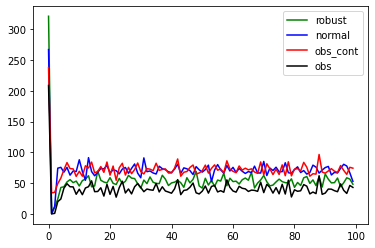

In [145]:
plt.plot(range(100), mu_robust, c='green', label='robust')
plt.plot(range(100), mu_normal, c='blue', label='normal')
plt.plot(range(100), obs_cont_mean, c='red', label='obs_cont')
plt.plot(range(100), obs_mean, c='black', label='obs')
plt.legend()

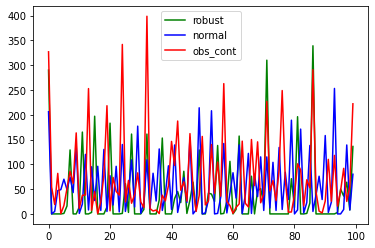

In [155]:
plt.plot(range(100), ricker_1(torch.tensor([4,10])).reshape(-1), c='green', label='robust')
plt.plot(range(100), ricker_1(torch.tensor([3,20])).reshape(-1), c='blue', label='normal')
plt.plot(range(100), obs_cont[0, 1], c='red', label='obs_cont')
# plt.plot(range(100), obs_mean, c='black', label='obs')
plt.legend()